**Pedro Paulo da Costa Pereira - A88062**<br>
**Tiago André Oliveira Leite - A91693**

# <center>TP1 Logica Computacional</center>

## Problema 2 - Sudoku
Da definição do jogo “Sudoku” generalizado para a dimensão $N$; o problema tradicional corresponde ao caso $N=3$. O objetivo do Sudoku é preencher uma grelha de $\,N^2\times N^2\,$ com inteiros positivos no intervalo $\,1$ até $\,N^2\,$, satisfazendo as seguintes regras:<br><br>
        - Cada inteiro no intervalo $\,1$ até $\,N^2\,$ocorre  só uma vez em cada coluna, linha e secção $\,N\times N\,$.<br><br>
        - No início do jogo uma fração $\,0\leq 𝛼< 1\,$ das $\,N^4\,$ casas da grelha são preenchidas de forma consistente com a regra anterior. 

### Variaveis do Problema
Para resolver o problema foram utilizadas $\,N^2\times N^2\times N^2\,$ variavies binarias, que nos premite verificar qual o número que vai ser colocado numa determinada linha e coluna da grelja do sudoku.<br>
Assim sendo foi definido o seguinte grupo de variavies:<br>
- $\quad cube_{row,col,depth}$ - variavel que represena o número $depth + 1$ na linha $row$ e na coluna $col$.


### Restrições
- $\forall_{row,col,row}$  $cube[(row,col,depth)] \in \{0,1\}$<br>
- $\forall_{row,col}\sum_{depth}$ $cube[(row,col,depth)] == 1$<br>
- $\forall_{row,depth}\sum_{col}$ $cube[(row,col,depth)] == 1$<br>
- $\forall_{depth,col}\sum_{row}$ $cube[(row,col,depth)] == 1$

Seja $n$ uma secção  $\,N\times N\,$ do cubo: <br>
- $\forall_{n_{row},n_{col}}\sum_{depth}$ $cube[(n_{row},n_{col},depth)] == 1$<br>
- $\forall_{n_{row},depth}\sum_{n_{row}}$ $cube[(n_{row},n_{col},depth)] == 1$<br>
- $\forall_{depth,n_{col}}\sum_{n_{row}}$ $cube[(n_{row},n_{col},depth)] == 1$



In [5]:
import math
import random
import timeit
import time
from ortools.linear_solver import pywraplp
import matplotlib.pyplot as plt

### Exemplo de sudoku

### Função que imprime a grelha do sudoku

In [6]:
def print_sudoku(sudoku):
    grid = 0 
    l = len(sudoku)
    n = int(math.sqrt(l))
    pad = 1 + l // 10
    r = (l + n) * (pad + 1)  +1
    if n > 4 and not grid:
        for i in range(l):
            for j in range(l):
                print(f'{sudoku[i][j]}'.ljust(pad), end = " ")
            print('')
        return 
                
    for i in range(l):
        if i % n == 0:
            print("-"*r)
        for j in range(l):
            if  j % n == 0:
                print("|".ljust(pad), end = " ")
            print(f'{sudoku[i][j]}'.ljust(pad), end = " ")
            if  j == l-1:
                print("|".ljust(pad), end = " ")
        print('')
    print("-" * r)

### Função auxiliar que converte o resultado do solver numa matriz

In [7]:
def converter(cube,dim):
    mat = [[0 for a in range(dim)] for b in range(dim) ]
    for row in range(dim):
        for col in range(dim):
            for depth in range(dim):
                if cube[(row,col,depth)].solution_value() == 1:
                    mat[row][col] = depth + 1
    return mat

### Função que inicializa a grelha do sudoku
Recebe como parametros a dimensão $N$ e a fracção $0 ≤ α < 1$ de casas que sao preenchidas. Para tal coloca $N$ números aletorios e depois tenta resolver o sudoku. De seguida apaga o número de números necessários para satisfazer α

In [80]:
def sudoku_generator(N, alpha):
    dim = N*N
    delete = int(dim * dim * (1-alpha))
    num_squares = int(math.sqrt(dim))
    solver = pywraplp.Solver.CreateSolver('SCIP')
    cube = {}
    
    if alpha == 0:
        mat = [[0 for c in range(dim)] for r in range(dim)]
        return mat
    
    
    for row in range(dim):
        for col in range(dim):
            for depth in range(dim):
                cube[(row,col,depth)] = solver.BoolVar('%i%i%i' % (row,col,depth))

    for row in range(dim):
        for col in range(dim):
            val = []
            for depth in range(dim):
                val.append(cube[(row,col,depth)])
            solver.Add(sum(val) == 1)

    for row in range(dim):
        for depth in range(dim):
            val = []
            for col in range(dim):
                val.append(cube[(row,col,depth)])
            solver.Add(sum(val) == 1)

    for depth in range(dim):
        for col in range(dim):
            val = []
            for row in range(dim):
                val.append(cube[(row, col, depth)])
            solver.Add(sum(val) == 1)

    for i in range(dim):
        corner_y = i - i % N
        for j in range(dim):
            corner_x = j - j % N
            for depth in range(dim):
                val = []
                for row in range(N):
                    for col in range(N):
                        val.append(cube[corner_y + row, corner_x + col, depth])
                solver.Add(sum(val) == 1)

    for i in range(N):
        randoms = []
        row = random.randint(0,dim-1)
        col = random.randint(0,dim-1)
        depth = random.randint(1, dim - 1)
        while (row,col) in randoms:
            row = random.randint(0,dim-1)
            col = random.randint(0,dim-1)
        solver.Add(cube[(row,col,depth)] == 1)
    
    status = solver.Solve()
    if status == pywraplp.Solver.OPTIMAL:
        mat = converter(cube, dim)
        while(delete > 0):
            row = random.randint(0,dim-1)
            col = random.randint(0,dim-1)
            while mat[row][col] == 0:
                row = random.randint(0, dim-1)
                col = random.randint(0, dim-1)
            mat[row][col] = 0
            delete -=1
        
        return mat
    else:
        return False

In [85]:
mat = sudoku_generator(3,0.2)
if mat:
    print_sudoku(mat)


-------------------------
| 0 0 0 | 4 5 0 | 0 0 8 | 
| 4 0 0 | 0 0 0 | 0 0 0 | 
| 0 0 9 | 0 0 0 | 0 0 0 | 
-------------------------
| 0 1 0 | 0 0 0 | 0 0 9 | 
| 0 0 0 | 0 0 0 | 2 0 0 | 
| 7 0 0 | 0 0 0 | 0 0 0 | 
-------------------------
| 5 3 0 | 0 0 2 | 8 0 0 | 
| 0 0 0 | 0 0 0 | 0 3 0 | 
| 0 0 2 | 0 0 0 | 0 5 1 | 
-------------------------


### Outra forma de inicializar o sudoku mas que produz sudokus impossiveis

In [15]:
def check(sudoku, row, column, number):
    if number in sudoku[row]:
        return False
    for r in sudoku:
        if r[column] == number:
            return False
    n = int(math.sqrt(len(sudoku)))
    r = (row // n) * n
    c = (column // n) * n
    for i in range(n):
        for j in range(n):
            if sudoku[r+i][c+j] == number:
                return False
    return True

def sudoku_generator_simple(N, alpha):
    dim = N*N
    filled = int(dim * dim * alpha)
    mat = [[0 for a in range(dim)] for a in range(dim)]
    while(filled > 0):
        row = random.randint(0,dim-1)
        col = random.randint(0,dim-1)
        number = random.randint(1, dim - 1)
        while(mat[row][col] != 0 or not check(mat,row,col,number)):
            row = random.randint(0, dim-1)
            col = random.randint(0, dim-1)
            number = random.randint(1,dim-1)
        mat[row][col] = number
        filled -=1

    return mat

In [16]:
mat = sudoku_generator_simple(5,0.2)
if mat:
    print_sudoku(mat)

0   0   0   0   0   4   0   0   1   0   0   0   3   0   0   0   0   0   12  0   0   0   0   0   0   
0   0   0   11  0   0   0   0   0   0   17  0   5   0   6   0   0   0   0   0   0   0   8   0   12  
0   0   0   0   0   0   21  0   0   22  0   0   7   0   0   0   0   20  10  1   0   0   19  0   0   
0   6   0   16  0   0   0   0   9   0   0   0   0   0   0   0   0   0   3   0   0   0   22  5   0   
0   0   21  0   0   0   0   0   0   0   0   0   0   0   0   0   0   16  0   14  0   0   0   0   0   
0   0   0   24  0   0   0   0   0   0   0   0   0   0   0   8   14  0   0   0   5   0   23  0   20  
0   0   0   0   7   0   0   0   0   18  0   0   0   15  0   0   0   0   0   0   8   0   0   3   14  
15  0   0   0   0   0   0   19  0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   4   
0   0   0   21  0   0   24  0   0   0   0   0   0   0   0   23  0   0   0   0   0   0   10  0   0   
0   22  1   2   0   0   0   9   14  8   0   0   0   0   0   24  0   0   15  0   0   0   0  

### Função que resolve o sudoku

In [10]:
def sudoku_solver(sudoku):
    solver = pywraplp.Solver.CreateSolver('SCIP')
    dim = len(sudoku)
    num_squares = int(math.sqrt(dim))
    cube = {}

    for row in range(dim):
        for col in range(dim):
            for depth in range(dim):
                cube[(row,col,depth)] = solver.BoolVar('%i%i%i' % (row,col,depth))


    for row in range(dim):
        for col in range(dim):
            val = []
            for depth in range(dim):
                val.append(cube[(row,col,depth)])
            solver.Add(sum(val) == 1)

    for row in range(dim):
        for depth in range(dim):
            val = []
            for col in range(dim):
                val.append(cube[(row,col,depth)])
            solver.Add(sum(val) == 1)

    for depth in range(dim):
        for col in range(dim):
            val = []
            for row in range(dim):
                val.append(cube[(row, col, depth)])
            solver.Add(sum(val) == 1)

    for i in range(dim):
        corner_y = i - i % num_squares
        for j in range(dim):
            corner_x = j - j % num_squares
            for depth in range(dim):
                val = []
                for row in range(num_squares):
                    for col in range(num_squares):
                        val.append(cube[corner_y + row, corner_x + col, depth])
                solver.Add(sum(val) == 1)

    for i in range(dim):
        for j in range(dim):
            if sudoku[i][j] != 0:
                solver.Add(cube[(i,j,sudoku[i][j]-1)] == 1)


    status = solver.Solve()
    mat = converter(cube, dim)
    if status == pywraplp.Solver.OPTIMAL:
        return mat
    else:
        return False

### Testes

In [23]:
def test_sudoku(N, alpha):
    mat = sudoku_generator(N, alpha)
    print("Sudoku")
    print_sudoku(mat)
    print("")
    mat = sudoku_solver(mat)
    if mat:
        print("Solução")
        print_sudoku(mat)
        print("")
    

In [39]:
N = [1,2,3]
times = [[0 for n in N] for n in N]

### $\alpha = 0.0$

#### $N = 3$

In [71]:
times[0][0] = timeit.timeit(stmt='test_sudoku(3,0.0)', setup='from __main__ import test_sudoku',number=1 )
times[0][0]

Sudoku
-------------------------
| 0 0 0 | 0 0 0 | 0 0 0 | 
| 0 0 0 | 0 0 0 | 0 0 0 | 
| 0 0 0 | 0 0 0 | 0 0 0 | 
-------------------------
| 0 0 0 | 0 0 0 | 0 0 0 | 
| 0 0 0 | 0 0 0 | 0 0 0 | 
| 0 0 0 | 0 0 0 | 0 0 0 | 
-------------------------
| 0 0 0 | 0 0 0 | 0 0 0 | 
| 0 0 0 | 0 0 0 | 0 0 0 | 
| 0 0 0 | 0 0 0 | 0 0 0 | 
-------------------------

Solução
-------------------------
| 1 2 3 | 4 5 6 | 8 7 9 | 
| 8 9 7 | 1 2 3 | 4 5 6 | 
| 6 4 5 | 7 8 9 | 1 2 3 | 
-------------------------
| 7 1 2 | 3 4 5 | 6 9 8 | 
| 9 5 6 | 2 1 8 | 3 4 7 | 
| 4 3 8 | 6 9 7 | 2 1 5 | 
-------------------------
| 5 8 1 | 9 3 2 | 7 6 4 | 
| 3 7 4 | 5 6 1 | 9 8 2 | 
| 2 6 9 | 8 7 4 | 5 3 1 | 
-------------------------



0.17216764199974932

#### $N = 4$

In [50]:
times[0][1] = timeit.timeit(stmt='test_sudoku(4,0.0)', setup='from __main__ import test_sudoku',number=1)
times[0][1]

Sudoku
-------------------------------------------------------------
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
-------------------------------------------------------------
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
-------------------------------------------------------------
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
---------------------------------------

1.9958298099998046

#### $N = 5$

In [51]:
times[0][2] = timeit.timeit(stmt='test_sudoku(5,0.0)', setup='from __main__ import test_sudoku',number=1)
times[0][2]

Sudoku
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

701.8026671130001

#### Tempos de Execução

[0.17216764199974932, 1.9958298099998046, 701.8026671130001]


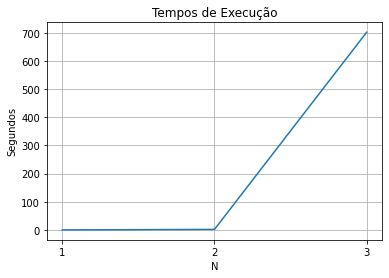

In [72]:
print(times[0])
plt.plot(N, times[0])
plt.xticks(N)
plt.title("Tempos de Execução")
plt.ylabel("Segundos")
plt.xlabel("N")
plt.grid(True)

### $\alpha = 0.2$

#### $N = 3$

In [70]:
times[1][0] = timeit.timeit(stmt='test_sudoku(3,0.2)', setup='from __main__ import test_sudoku',number=1 )
times[1][0]

Sudoku
-------------------------
| 0 0 0 | 0 0 0 | 0 0 0 | 
| 0 8 0 | 0 0 0 | 0 3 9 | 
| 0 0 4 | 0 0 0 | 7 0 0 | 
-------------------------
| 0 0 0 | 0 2 1 | 0 6 0 | 
| 3 0 2 | 0 0 0 | 0 0 0 | 
| 0 0 0 | 0 5 0 | 0 0 0 | 
-------------------------
| 0 0 0 | 0 3 0 | 0 2 4 | 
| 0 0 0 | 0 4 0 | 0 9 0 | 
| 0 0 0 | 0 9 0 | 0 0 0 | 
-------------------------

Solução
-------------------------
| 1 2 3 | 4 7 9 | 5 8 6 | 
| 5 8 7 | 2 1 6 | 4 3 9 | 
| 6 9 4 | 3 8 5 | 7 1 2 | 
-------------------------
| 4 5 8 | 7 2 1 | 9 6 3 | 
| 3 1 2 | 9 6 4 | 8 5 7 | 
| 7 6 9 | 8 5 3 | 2 4 1 | 
-------------------------
| 9 7 1 | 5 3 8 | 6 2 4 | 
| 2 3 5 | 6 4 7 | 1 9 8 | 
| 8 4 6 | 1 9 2 | 3 7 5 | 
-------------------------



0.1423791369998071

#### $N = 4$

In [50]:
times[1][1] = timeit.timeit(stmt='test_sudoku(4,0.2)', setup='from __main__ import test_sudoku',number=1)
times[1][1]

Sudoku
-------------------------------------------------------------
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
-------------------------------------------------------------
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
-------------------------------------------------------------
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
---------------------------------------

1.9958298099998046

#### $N = 5$

In [51]:
times[1][2] = timeit.timeit(stmt='test_sudoku(5,0.2)', setup='from __main__ import test_sudoku',number=1)
times[1][2]

Sudoku
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

701.8026671130001

#### Tempos de Execução

[0.14464685100006136, 1.9958298099998046, 701.8026671130001]


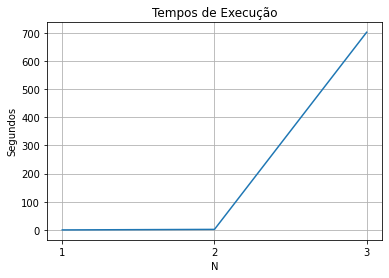

In [67]:
print(times[1])
plt.plot(N, times[1])
plt.xticks(N)
plt.title("Tempos de Execução")
plt.ylabel("Segundos")
plt.xlabel("N")
plt.grid(True)

### $\alpha = 0.4$

#### $N = 3$

In [43]:
times[2][0] = timeit.timeit(stmt='test_sudoku(3,0.4)', setup='from __main__ import test_sudoku',number=1 )
times[2][0]

Sudoku
-------------------------
| 0 0 0 | 0 0 0 | 0 0 0 | 
| 0 0 0 | 0 0 0 | 0 0 0 | 
| 0 0 0 | 0 0 0 | 0 0 0 | 
-------------------------
| 0 0 0 | 0 0 0 | 0 0 0 | 
| 0 0 0 | 0 0 0 | 0 0 0 | 
| 0 0 0 | 0 0 0 | 0 0 0 | 
-------------------------
| 0 0 0 | 0 0 0 | 0 0 0 | 
| 0 0 0 | 0 0 0 | 0 0 0 | 
| 0 0 0 | 0 0 0 | 0 0 0 | 
-------------------------

Solução
-------------------------
| 1 2 3 | 4 5 6 | 8 7 9 | 
| 8 9 7 | 1 2 3 | 4 5 6 | 
| 6 4 5 | 7 8 9 | 1 2 3 | 
-------------------------
| 7 1 2 | 3 4 5 | 6 9 8 | 
| 9 5 6 | 2 1 8 | 3 4 7 | 
| 4 3 8 | 6 9 7 | 2 1 5 | 
-------------------------
| 5 8 1 | 9 3 2 | 7 6 4 | 
| 3 7 4 | 5 6 1 | 9 8 2 | 
| 2 6 9 | 8 7 4 | 5 3 1 | 
-------------------------



0.14464685100006136

#### $N = 4$

In [50]:
times[2][1] = timeit.timeit(stmt='test_sudoku(4,0.4)', setup='from __main__ import test_sudoku',number=1)
times[2][1]

Sudoku
-------------------------------------------------------------
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
-------------------------------------------------------------
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
-------------------------------------------------------------
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
---------------------------------------

1.9958298099998046

#### $N = 5$

In [51]:
times[2][2] = timeit.timeit(stmt='test_sudoku(5,0.4)', setup='from __main__ import test_sudoku',number=1)
times[2][2]

Sudoku
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

701.8026671130001

#### Tempos de Execução

[0.14464685100006136, 1.9958298099998046, 701.8026671130001]


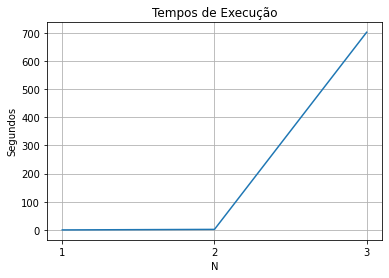

In [67]:
print(times[2])
plt.plot(N, times[2])
plt.xticks(N)
plt.title("Tempos de Execução")
plt.ylabel("Segundos")
plt.xlabel("N")
plt.grid(True)

In [39]:
N = [1,2,3]
times = [[0 for n in N] for n in N]

### $\alpha = 0.6$

#### $N = 3$

In [43]:
times[3][0] = timeit.timeit(stmt='test_sudoku(3,0.6)', setup='from __main__ import test_sudoku',number=1 )
times[3][0]

Sudoku
-------------------------
| 0 0 0 | 0 0 0 | 0 0 0 | 
| 0 0 0 | 0 0 0 | 0 0 0 | 
| 0 0 0 | 0 0 0 | 0 0 0 | 
-------------------------
| 0 0 0 | 0 0 0 | 0 0 0 | 
| 0 0 0 | 0 0 0 | 0 0 0 | 
| 0 0 0 | 0 0 0 | 0 0 0 | 
-------------------------
| 0 0 0 | 0 0 0 | 0 0 0 | 
| 0 0 0 | 0 0 0 | 0 0 0 | 
| 0 0 0 | 0 0 0 | 0 0 0 | 
-------------------------

Solução
-------------------------
| 1 2 3 | 4 5 6 | 8 7 9 | 
| 8 9 7 | 1 2 3 | 4 5 6 | 
| 6 4 5 | 7 8 9 | 1 2 3 | 
-------------------------
| 7 1 2 | 3 4 5 | 6 9 8 | 
| 9 5 6 | 2 1 8 | 3 4 7 | 
| 4 3 8 | 6 9 7 | 2 1 5 | 
-------------------------
| 5 8 1 | 9 3 2 | 7 6 4 | 
| 3 7 4 | 5 6 1 | 9 8 2 | 
| 2 6 9 | 8 7 4 | 5 3 1 | 
-------------------------



0.14464685100006136

#### $N = 4$

In [50]:
times[3][1] = timeit.timeit(stmt='test_sudoku(4,0.6)', setup='from __main__ import test_sudoku',number=1)
times[3][1]

Sudoku
-------------------------------------------------------------
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
-------------------------------------------------------------
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
-------------------------------------------------------------
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
|  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  0  0  0  0  |  
---------------------------------------

1.9958298099998046

#### $N = 5$

In [51]:
times[0][3] = timeit.timeit(stmt='test_sudoku(5,0.6)', setup='from __main__ import test_sudoku',number=1)
times[0][3]

Sudoku
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

701.8026671130001

#### Tempos de Execução

[0.14464685100006136, 1.9958298099998046, 701.8026671130001]


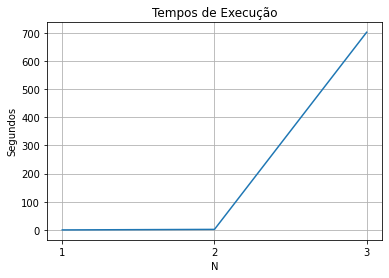

In [67]:
print(times[3])
plt.plot(N, times[3])
plt.xticks(N)
plt.title("Tempos de Execução")
plt.ylabel("Segundos")
plt.xlabel("N")
plt.grid(True)

### Nota

Para $N = 5$ a função demora varios minutos a executar, o que deve ser provocado pelo ao facto de as soluções terem complexidade exponencial em $N$. Neste caso, o problema vai ter $\,5^2\times 5^2\times 5^2\, = \,25^3\, = 15625$ variaveis.